**  KAGGLE AUTHENTICATION THROUGH UPLOADING API FILE**

In [0]:
import zipfile
from google.colab import auth
auth.authenticate_user()

In [3]:
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 May 16 07:32 kaggle.json
{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}

In [6]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 5.3MB 15.5MB/s 
     |████████████████████████████████| 51kB 24.4MB/s 
     |████████████████████████████████| 102kB 38.6MB/s 
     |████████████████████████████████| 112kB 60.7MB/s 


**DOWNLOADING AND UNZIPPING FILES**

In [7]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 88.6MB/s]
 98% 5.00M/5.10M [00:00<00:00, 43.2MB/s]
100% 5.10M/5.10M [00:00<00:00, 32.5MB/s]
 98% 1.28G/1.30G [00:12<00:00, 84.9MB/s]
100% 1.30G/1.30G [00:13<00:00, 107MB/s] 
100% 4.96G/4.98G [00:51<00:00, 136MB/s]
100% 4.98G/4.98G [00:51<00:00, 103MB/s]


In [0]:

zipf = zipfile.ZipFile('../content/train.zip')
zipf.extractall('../content/train')

In [0]:
zipf = zipfile.ZipFile('../content/test.zip')
zipf.extractall('../content/test/test')

In [0]:
! rm -r ../content/train_labels.csv
zipf = zipfile.ZipFile('../content/train_labels.csv.zip')
zipf.extractall()

In [12]:
# Añadir la extensión .tiff en el csv con los labels, para que el flow_from_dataframe pueda leer las imagenes.
import pandas as pd
df = pd.read_csv('../content/train_labels.csv')

df['label'] = df['label'].astype(str)
df['id'] = df['id'].apply(lambda x: x+'.tif')

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [0]:
# Split en validation/train
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

In [14]:
import keras
from keras_preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [15]:
datagen=ImageDataGenerator(rescale=1./255
                          #rotation_range=45,
                          #horizontal_flip=True,
                          #vertical_flip=True,
                          #width_shift_range=0.05,
                          #height_shift_range=0.05,
                          #zoom_range=0.05,
                          )

train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="categorical", 
                                            target_size=(32,32), 
                                            batch_size=256)

validation_generator=datagen.flow_from_dataframe(dataframe=valid_df, 
                                                 directory="../content/train", 
                                                 x_col="id", y_col="label", 
                                                 class_mode="categorical", 
                                                 target_size=(32,32), 
                                                 batch_size=256)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


**NN MODEL**

In [16]:
from keras import models
from keras import layers
from keras.layers.convolutional import SeparableConv2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import optimizers

model = models.Sequential()
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), depth_multiplier=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu', depth_multiplier=2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(layers.SeparableConv2D(64, (3, 3), activation='relu', depth_multiplier=5))
model.add(layers.SeparableConv2D(64, (3, 3), activation='relu', depth_multiplier=5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

optimizer = optimizers.RMSprop()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 30, 30, 32)        278       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 13, 13, 32)        2656      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 4, 4, 64)          11744     
_________________________________________________________________
separable_conv2d_4 (S

In [0]:
from keras import callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.025, patience=10, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.025, patience=5, min_lr=0.001, factor=0.5, verbose=1)
model_checker=callbacks.ModelCheckpoint(filepath='models/' + 'first_model', monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=1)
tensorboard = callbacks.TensorBoard(log_dir='logs/first_model')

In [21]:
n_epochs = 2
batch_size=64

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [early_stop, reduce_lr, model_checker, tensorboard],
    epochs = n_epochs)

Epoch 1/2
2750/2750 [==============================] - 1179s 429ms/step - loss: 0.2566 - acc: 0.8926 - val_loss: 0.3574 - val_acc: 0.8646
Epoch 2/2
   3/2750 [..............................] - ETA: 2:56 - loss: 0.2515 - acc: 0.9010

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2750/2750 [==============================] - 1175s 427ms/step - loss: 0.2513 - acc: 0.8951 - val_loss: 0.3727 - val_acc: 0.8310


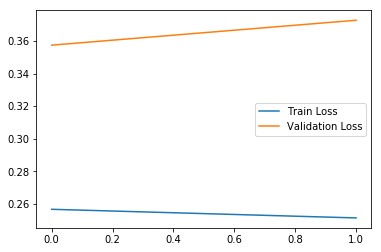

In [22]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

**GENERATE THE PREDICTIONS**





In [23]:
test_dir = '../content/test/test'
test_datagen = ImageDataGenerator(rescale=1./255)


print(os.getcwd()+os.path.sep+test_dir)
test_generator = test_datagen.flow_from_directory(
        '../content/test',
        target_size=(32, 32),
        color_mode="rgb",
        batch_size=2,
        shuffle=False)
filenames = test_generator.filenames
nb_samples = len(filenames)

/content/../content/test/test
Found 57458 images belonging to 1 classes.


In [24]:
predictions = model.predict_generator(test_generator,steps = nb_samples//2, verbose=1)

28729/28729 [==============================] - 2510s 87ms/step


In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [26]:
predictions[:10]

array([[0.04619971, 0.9538003 ],
       [0.11459529, 0.88540477],
       [0.21489918, 0.7851009 ],
       [0.5253854 , 0.47461462],
       [0.84704065, 0.15295935],
       [0.7680728 , 0.2319272 ],
       [0.99263966, 0.00736031],
       [0.77215856, 0.22784145],
       [0.8666193 , 0.13338073],
       [0.09352587, 0.9064742 ]], dtype=float32)

In [0]:
import numpy as np
predicted_class_indices=np.argmax(predictions,axis=1)

In [28]:
predicted_class_indices[:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

In [0]:
predictions = [labels[k] for k in predicted_class_indices]

**UPLOAD THE PREDICTIONS TO KAGGLE**

In [30]:
filenames=test_generator.filenames
print(filenames[:10])

['test/00006537328c33e284c973d7b39d340809f7271b.tif', 'test/0000ec92553fda4ce39889f9226ace43cae3364e.tif', 'test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', 'test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', 'test/000270442cc15af719583a8172c87cd2bd9c7746.tif', 'test/000309e669fa3b18fb0ed6a253a2850cce751a95.tif', 'test/000360e0d8358db520b5c7564ac70c5706a0beb0.tif', 'test/00040095a4a671280aeb66cb0c9231e6216633b5.tif', 'test/000698b7df308d75ec9559ef473a588c513a68aa.tif', 'test/0006e1af5670323331d09880924381d67d79eda0.tif']


In [31]:
# Remove .tiff extension and /test at the beginning
filenames = [x[:-4] for x in filenames]
filenames = [x[5:] for x in filenames]
print(filenames[:5])

['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746']


In [0]:
results=pd.DataFrame({"id":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

In [34]:
import kaggle
!kaggle competitions submit histopathologic-cancer-detection -f "../content/results.csv" -m "My enhanced network"

100% 2.36M/2.36M [00:03<00:00, 804kB/s]
Successfully submitted to Histopathologic Cancer Detection

Private score: 0.7504
Public score: 0.7672